In [1]:
import sys
import os
from os.path import abspath, join as path_join
import numpy as np
import ConfigSpace as CS
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
PARENT_DIR =  path_join(os.getcwd(), "..")
sys.path.insert(0, PARENT_DIR)
from autoda.data_augmentation import ImageAugmentation
from fanova import fANOVA
from fanova import visualizer



sns.set_style(style='whitegrid')


plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('font', size=15.0, family='serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


Using TensorFlow backend.


In [6]:
results_path = path_join(abspath("."), "..", "experiments/results")

msg = "Results to plot do not exist. Check path. {}".format(results_path)
assert os.path.exists(results_path), msg

datasets = ["mnist"]

results = dict()


r = dict()
for d in datasets:
    p = dict()
    validation_accuracy = []
    validation_loss = []
    runtime = []
    config_ids = []
    configs=[]
    params = []
    pad = []
    rescale = []
    horizontal_flip = []
    vertical_flip = []
    rotation = []
    
    path = path_join(abspath("."), "..", "experiments/results")
    #n_runs = len([name for name in os.listdir(path_join(path, "mnist"))])
    n_runs = 1000
    for i in range(1, n_runs):
        try:
            from os.path import abspath, join as path_join
            config_path = "%s/config_%d.json" % (d, i)
            filename = path_join(path, config_path)
            with open(filename, "r") as f:
                res = json.load(f)
        except FileNotFoundError:
            print(i, d)
            continue

        runtime.append(res['runtime'])
        configs.append(res['configs'])

        config_ids.append(res["config_id"])
        validation_accuracy.append(res["validation_accuracy"])
        pad.append(res["configs"]["pad"])
        rescale.append(res['configs']['rescale'])
        horizontal_flip.append(res['configs']['horizontal_flip'])
        vertical_flip.append(res['configs']['vertical_flip'])
        rotation.append(res['configs']['rotation_range'])


    p['validation_accuracy'] = np.array(validation_accuracy)
    p["runtime"] = np.array(runtime)
    #p["params"] = params
    p['configs'] = configs
    p['config_ids'] = config_ids
    p['pad'] = pad
    p['rescale'] = rescale
    p["horizontal_flip"] = horizontal_flip
    p['vertical_flip'] = vertical_flip
    p['rotation'] = rotation
    results[d] = p
    


PDF plots of validation accuracy results on augmented MNIST image data

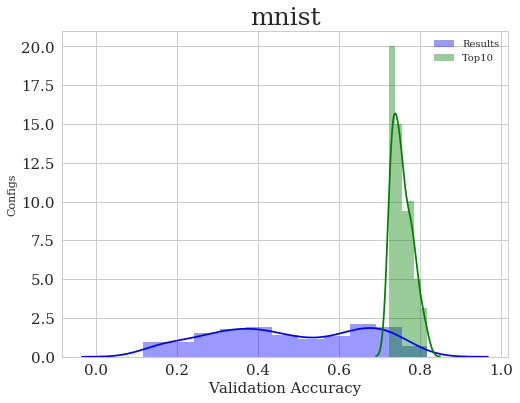

In [73]:
dataset = "mnist"
validation_accuracy = results[dataset]["validation_accuracy"]
top10 = np.sort(validation_accuracy)[-100:]
sns.distplot(validation_accuracy, label='Results', norm_hist=True,  color="blue")
sns.distplot(top10, label='Top10', norm_hist=True, color="green")
plt.legend()
plt.ylabel("Configs")
plt.xlabel("Validation Accuracy", fontsize=15)
plt.title(dataset, fontsize=25)

CDF Plots

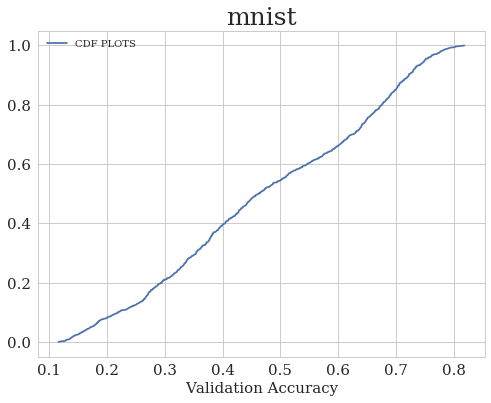

In [10]:
sorted_accuracy = np.sort(validation_accuracy)
yvals = np.arange(len(sorted_accuracy)) / float(len(sorted_accuracy))
plt.plot(sorted_accuracy, yvals, label= "CDF PLOTS")
plt.legend(loc=2, fontsize=10)
plt.xlabel("Validation Accuracy", fontsize=15)
plt.title(dataset, fontsize=25)


Plots with parameters, for example with padding and validation accuracy

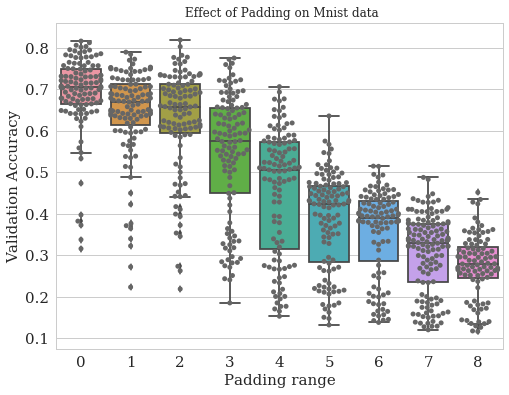

In [68]:
#plt.scatter(x=pad, y=validation_accuracy)

validation_accuracy = results[dataset]["validation_accuracy"]
rescale= results[dataset]["pad"]
ax = sns.boxplot(x=pad, y=validation_accuracy)
ax = sns.swarmplot(x=pad, y=validation_accuracy, color=".40")
ax.set_title(' Effect of Padding on Mnist data')

plt.xlabel("Padding Range", size=15)
plt.ylabel("Validation Accuracy", size=15)


Effect of Rescale on Mnist data

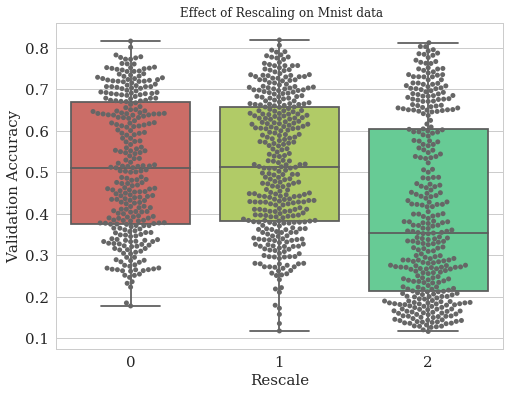

In [69]:

validation_accuracy = results[dataset]["validation_accuracy"]
rescale= results[dataset]["rescale"]
ax = sns.boxplot(x=rescale, y=validation_accuracy)
ax = sns.swarmplot(x=rescale, y=validation_accuracy, color=".40")
ax.set_title(' Effect of Rescaling on Mnist data')
plt.xlabel("Rescale", size=15)
plt.ylabel("Validation Accuracy", size=15)

Plot to show effect of Horizontal Flip on Mnist Data

999


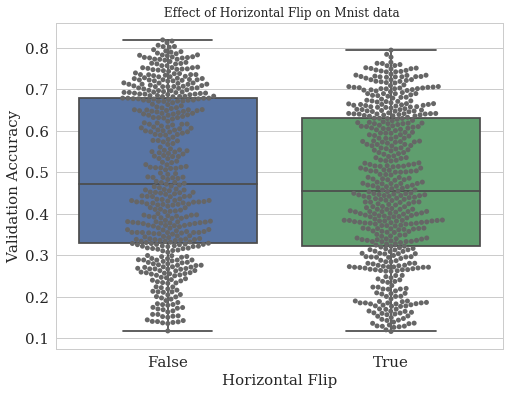

In [5]:
dataset = "mnist"
validation_accuracy = results[dataset]["validation_accuracy"]
hor_flip= results[dataset]["horizontal_flip"]
ax = sns.boxplot(x=hor_flip, y=validation_accuracy)
ax = sns.swarmplot(x=hor_flip, y=validation_accuracy, color=".40")
ax.set_title(' Effect of Horizontal Flip on Mnist data')
plt.xlabel("Horizontal Flip", size=15)
plt.ylabel("Validation Accuracy", size=15)

Effect of Rotation Range on Mnist Data

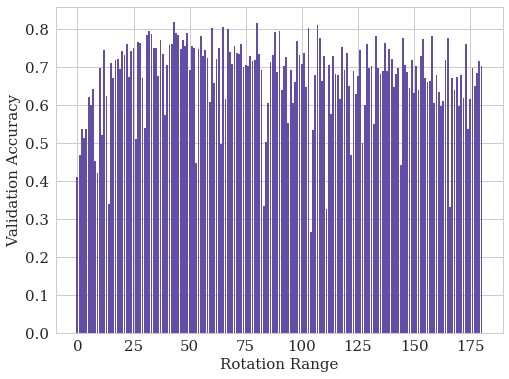

In [79]:
dataset = "mnist"
validation_accuracy = results[dataset]["validation_accuracy"]
rotation= results[dataset]["rotation"]
plt.bar(rotation, validation_accuracy, color="#624ea7")
#ax = sns.boxplot(x=rotation, y=validation_accuracy)
#ax = sns.swarmplot(x=rotation, y=validation_accuracy, color=".40")
#ax.set_title(' Effect of Rotation on Mnist data')
plt.xlabel("Rotation Range", size=15)
plt.ylabel("Validation Accuracy", size=15)


Make FANOVA Plots

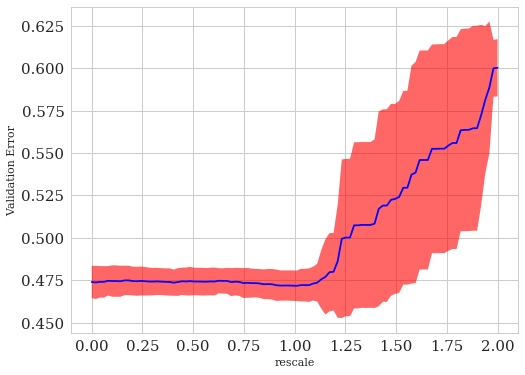

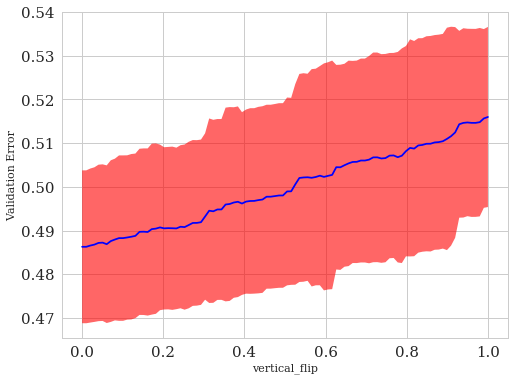

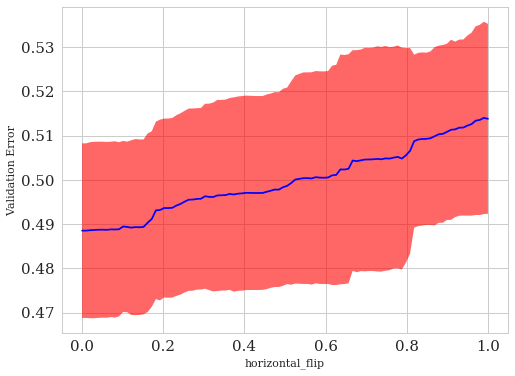

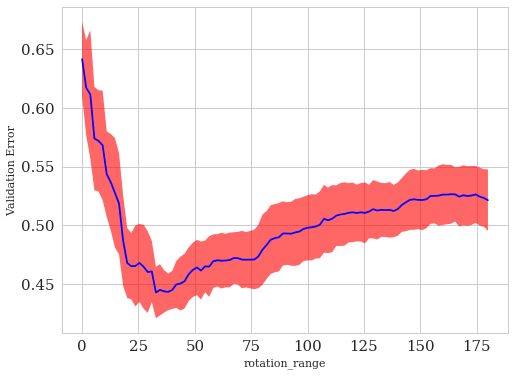

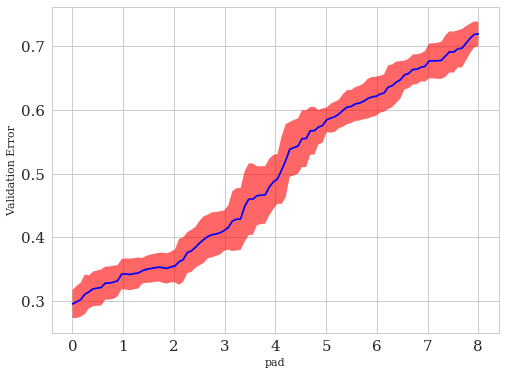

In [41]:
dataset = "mnist"

order= ['rescale', 'vertical_flip', 'horizontal_flip', 'rotation_range', 'pad'] # change order to params
config_space = ImageAugmentation.get_config_space()


X = []

for c in results[dataset]["configs"]:
    vec = []
    for j, k in enumerate(order):
        if c[k] is not None: 
            vec.append(c[k])
            
        else:
            vec.append(0)
    X.append(vec)
X = np.array(X)
y = results[dataset]["validation_accuracy"]
y_error = 1- y
f = fANOVA(X, y_error)
vis = visualizer.Visualizer(f, f.cs)

for i in range(len(order)):
    plt = vis.plot_marginal(i, show=False)
    plt.xlabel(order[i])
    plt.ylabel("Validation Error")
    plt.show()


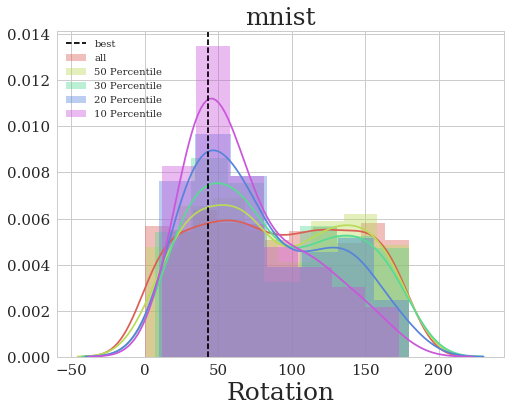

In [33]:
dataset = "mnist"

order= ['rescale', 'vertical_flip', 'horizontal_flip', 'rotation_range', 'pad'] # change order to params
config_space = ImageAugmentation.get_config_space()


X = []

for c in results[dataset]["configs"]:
    vec = []
    for j, k in enumerate(order):
        if c[k] is not None: 
            vec.append(c[k])
            
        else:
            vec.append(0)
    X.append(vec)
X = np.array(X)
y = results[dataset]["validation_accuracy"]

current_palette= sns.color_palette("hls", 5)

sns.set_palette(current_palette)
sns.distplot(X[:, 3], label='all', norm_hist=True) # use named tuple here

y = 1 - y


p = np.percentile(y, 50)
perc_50 = np.where(y < p)
sns.distplot(X[perc_50, 3], label='50 Percentile', norm_hist=True)

p = np.percentile(y, 30)
perc_30 = np.where(y < p)
sns.distplot(X[perc_30, 3], label='30 Percentile', norm_hist=True)

p = np.percentile(y, 20)
perc_20 = np.where(y < p)
sns.distplot(X[perc_20, 3], label='20 Percentile', norm_hist=True)

p = np.percentile(y, 10)
perc_10 = np.where(y < p)
sns.distplot(X[perc_10, 3], label='10 Percentile', norm_hist=True)


idx = np.argmin(y)
plt.axvline(X[idx, 3], linestyle="--", color="black", label="best")
plt.title(dataset, fontsize=25)
plt.xlabel('Rotation', size=25)
plt.legend(loc=2)
plt.show()

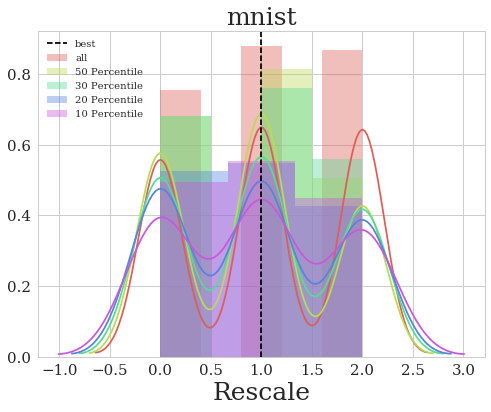

In [35]:
dataset = "mnist"

order= ['rescale', 'vertical_flip', 'horizontal_flip', 'rotation_range', 'pad'] # change order to params
config_space = ImageAugmentation.get_config_space()


X = []

for c in results[dataset]["configs"]:
    vec = []
    for j, k in enumerate(order):
        if c[k] is not None: 
            vec.append(c[k])
            
        else:
            vec.append(0)
    X.append(vec)
X = np.array(X)
y = results[dataset]["validation_accuracy"]

current_palette= sns.color_palette("hls", 5)

sns.set_palette(current_palette)
sns.distplot(X[:, 0], label='all', norm_hist=True) # use named tuple here

y = 1 - y


p = np.percentile(y, 50)
perc_50 = np.where(y < p)
sns.distplot(X[perc_50, 0], label='50 Percentile', norm_hist=True)

p = np.percentile(y, 30)
perc_30 = np.where(y < p)
sns.distplot(X[perc_30, 0], label='30 Percentile', norm_hist=True)

p = np.percentile(y, 20)
perc_20 = np.where(y < p)
sns.distplot(X[perc_20, 0], label='20 Percentile', norm_hist=True)

p = np.percentile(y, 10)
perc_10 = np.where(y < p)
sns.distplot(X[perc_10, 0], label='10 Percentile', norm_hist=True)


idx = np.argmin(y)
plt.axvline(X[idx, 0], linestyle="--", color="black", label="best")
plt.title(dataset, fontsize=25)
plt.xlabel('Rescale', size=25)
plt.legend(loc=2)
plt.show()

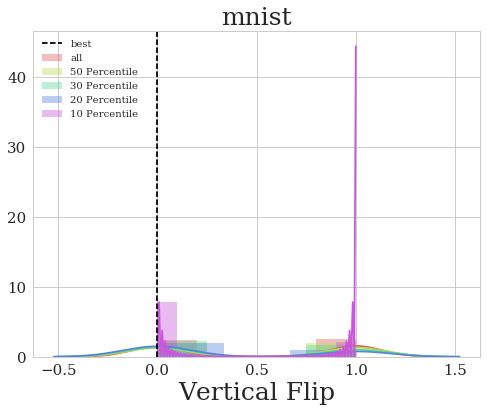

In [37]:
dataset = "mnist"

order= ['rescale', 'vertical_flip', 'horizontal_flip', 'rotation_range', 'pad'] # change order to params
config_space = ImageAugmentation.get_config_space()


X = []

for c in results[dataset]["configs"]:
    vec = []
    for j, k in enumerate(order):
        if c[k] is not None: 
            vec.append(c[k])
            
        else:
            vec.append(0)
    X.append(vec)
X = np.array(X)
y = results[dataset]["validation_accuracy"]

current_palette= sns.color_palette("hls", 5)

sns.set_palette(current_palette)
sns.distplot(X[:, 1], label='all', norm_hist=True) # use named tuple here

y = 1 - y


p = np.percentile(y, 50)
perc_50 = np.where(y < p)
sns.distplot(X[perc_50, 1], label='50 Percentile', norm_hist=True)

p = np.percentile(y, 30)
perc_30 = np.where(y < p)
sns.distplot(X[perc_30, 1], label='30 Percentile', norm_hist=True)

p = np.percentile(y, 20)
perc_20 = np.where(y < p)
sns.distplot(X[perc_20, 1], label='20 Percentile', norm_hist=True)

p = np.percentile(y, 10)
perc_10 = np.where(y < p)
sns.distplot(X[perc_10, 1], label='10 Percentile', norm_hist=True)


idx = np.argmin(y)
plt.axvline(X[idx, 1], linestyle="--", color="black", label="best")
plt.title(dataset, fontsize=25)
plt.xlabel('Vertical Flip', size=25)
plt.legend(loc=2)
plt.show()

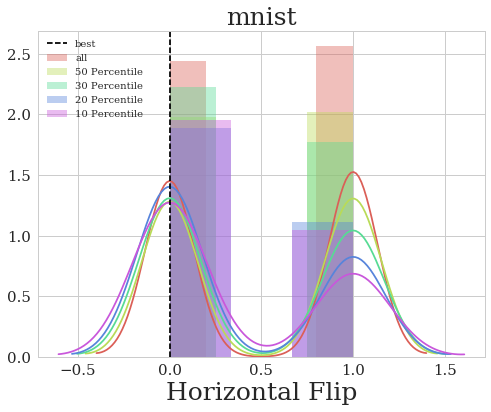

In [39]:
dataset = "mnist"

order= ['rescale', 'vertical_flip', 'horizontal_flip', 'rotation_range', 'pad'] # change order to params
config_space = ImageAugmentation.get_config_space()


X = []

for c in results[dataset]["configs"]:
    vec = []
    for j, k in enumerate(order):
        if c[k] is not None: 
            vec.append(c[k])
            
        else:
            vec.append(0)
    X.append(vec)
X = np.array(X)
y = results[dataset]["validation_accuracy"]

current_palette= sns.color_palette("hls", 5)

sns.set_palette(current_palette)
sns.distplot(X[:, 2], label='all', norm_hist=True) # use named tuple here

y = 1 - y


p = np.percentile(y, 50)
perc_50 = np.where(y < p)
sns.distplot(X[perc_50, 2], label='50 Percentile', norm_hist=True)

p = np.percentile(y, 30)
perc_30 = np.where(y < p)
sns.distplot(X[perc_30, 2], label='30 Percentile', norm_hist=True)

p = np.percentile(y, 20)
perc_20 = np.where(y < p)
sns.distplot(X[perc_20, 2], label='20 Percentile', norm_hist=True)

p = np.percentile(y, 10)
perc_10 = np.where(y < p)
sns.distplot(X[perc_10, 2], label='10 Percentile', norm_hist=True)


idx = np.argmin(y)
plt.axvline(X[idx, 2], linestyle="--", color="black", label="best")
plt.title(dataset, fontsize=25)
plt.xlabel('Horizontal Flip', size=25)
plt.legend(loc=2)
plt.show()

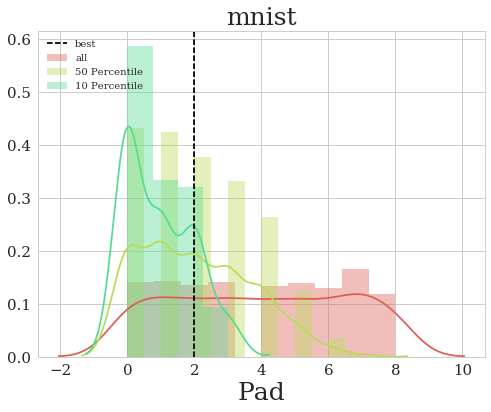

In [44]:
dataset = "mnist"

order= ['rescale', 'vertical_flip', 'horizontal_flip', 'rotation_range', 'pad'] # change order to params
config_space = ImageAugmentation.get_config_space()


X = []

for c in results[dataset]["configs"]:
    vec = []
    for j, k in enumerate(order):
        if c[k] is not None: 
            vec.append(c[k])
            
        else:
            vec.append(0)
    X.append(vec)
X = np.array(X)
y = results[dataset]["validation_accuracy"]

current_palette= sns.color_palette("hls", 5)

sns.set_palette(current_palette)
sns.distplot(X[:, 4], label='all', norm_hist=True) # use named tuple here

y = 1 - y


p = np.percentile(y, 50)
perc_50 = np.where(y < p)
sns.distplot(X[perc_50, 4], label='50 Percentile', norm_hist=True)
"""
p = np.percentile(y, 30)
perc_30 = np.where(y < p)
sns.distplot(X[perc_30, 4], label='30 Percentile', norm_hist=True)

p = np.percentile(y, 20)
perc_20 = np.where(y < p)
sns.distplot(X[perc_20, 4], label='20 Percentile', norm_hist=True)
"""
p = np.percentile(y, 10)
perc_10 = np.where(y < p)
sns.distplot(X[perc_10, 4], label='10 Percentile', norm_hist=True)


idx = np.argmin(y)
plt.axvline(X[idx, 4], linestyle="--", color="black", label="best")
plt.title(dataset, fontsize=25)
plt.xlabel('Pad', size=25)
plt.legend(loc=2)
plt.show()